In [1]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import theano
import scipy.stats as stats
import scipy
import seaborn as sns
sns.set(color_codes=True)

In [2]:
# Set logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('bayesian_glm')

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

<H3> Select Dataset </H3>

In [4]:
file_index = 0

x, y = xy_op(file_index)
data = dict(x=x, y=y)

INFO:bayesian_glm:reading file data_1_1.csv
INFO:bayesian_glm:shape of [X] is (100,)
/Users/shashank/.virtualenvs/vvf/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
INFO:bayesian_glm:shape of [Y] is (100,)
/Users/shashank/.virtualenvs/vvf/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


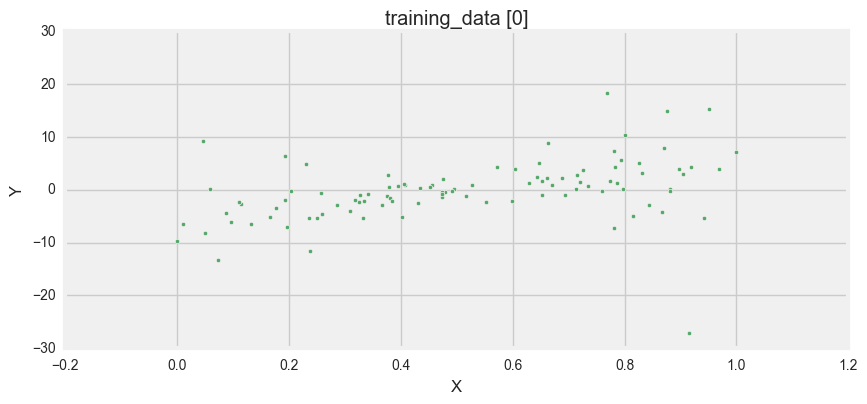

In [9]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(211)
ax.scatter(x[:], y[:], s=10, c='g')
ax.set_ylabel("Y")
ax.set_xlabel('X')
ax.set_title("training_data [{}]".format(file_index))
ax.legend() 

ax = fig.add_subplot(211)

fig.show()

In [5]:
class LinearModelWithError(object):
    
    
    def __init__(self, file_name):
        self.file_name = file_name
        (self.x, self.y) = self.xy_op(file_name)
        self.model = self.model(self.x, self.y)
        
        
    @staticmethod        
    def xy_op(file_name):

        logger.info("reading file {}".format(file_name))
        df = pd.read_csv(file_name)
        exog = df['x'].as_matrix()
        endo = df['y'].as_matrix()

        sample_size = exog.shape[0]

        x = exog
        logger.info("shape of [X] is {}".format(x.shape))
        logger.debug("[X] is {}".format(x[:3]))

        from sklearn import preprocessing
        x_scaler = preprocessing.MinMaxScaler().fit(x)

        y = endo
        logger.info("shape of [Y] is {}".format(y.shape))
        logger.debug("[Y] is {}".format(y[:3]))

        return (x_scaler.transform(x), y)
    
    
    @staticmethod
    def model(x, y):
        """
        Student T distribution

        This one with uniform priors

        Parameters
            ----------
            nu : int
                Degrees of freedom (nu > 0).
            mu : float
                Location parameter.
            lam : float
                Scale parameter (lam > 0).
        """
        with pm.Model() as vvf_model:

            # Define priors
            b0 = pm.Normal("b0", mu=0, sd=20)
            b1 = pm.Normal("b1", mu=0, sd=20)
            lam = pm.Uniform("lam", lower=0.0, upper=20.0)
            nu = pm.Uniform("nu", lower=0.0, upper=20.0)

            # Identity Link Function 
            mu = b0 + b1*x

            y_obs = pm.StudentT("y_obs", mu=mu, lam=lam, nu=nu, observed=y)
        
        return vvf_model
    
    
    def mcmc(self):
        
        with self.model as vvf_model:
            start = pm.find_MAP(model=vvf_model, fmin=scipy.optimize.fmin_powell)
            logger.info("Starting values = {}".format(start))

            # draw posterior samples
            trace = pm.sampling.sample(10000, start=start)    
        return trace
            
    
    def result_and_diagnostics(self):
        
        print("Results and Diagnostics for {}".format(self.file_name))
        x, y = self.x, self.y
        
        # plot the trace
        trace = self.mcmc()
        pm.plots.traceplot(trace)
        
        # plot the ppc
        """
        <H4> Posterior Predictive Distribution </H4>

        ```
        contains 500 generated data sets (containing 100 samples each), 
        each using a different parameter setting from the posterior
        ```
        """
        ppc = pm.sampling.sample_ppc(trace, samples=500, model=self.model)

        
        # posterior predictive mean
        def plot_posterior_predictive_mean(ax):
            # Posterior Predictive of the mean
            sns.distplot([np.mean(n) for n in ppc['y_obs']], kde=False, ax=ax)
            ax.axvline(y.mean())
            ax.set(title='Posterior predictive of the mean', xlabel='mean(y_obs)', ylabel='Frequency');

            
        # posterior cdf
        def plot_posterior_cdf(ax):
            sns.distplot(y,
                 hist_kws=dict(cumulative=True),
                 kde_kws=dict(cumulative=True),
                 ax=ax)
            sns.distplot(y,
                 hist_kws=dict(cumulative=True),
                 kde_kws=dict(cumulative=True),
                 ax=ax)

            # Posterior Predictive of the mean
            sns.distplot([n.mean() for n in ppc['y_obs']], kde=False, ax=ax)
            ax.axvline(y.mean())
            ax.set(title='Posterior predictive of the mean', xlabel='mean(y_obs)', ylabel='Frequency');


        # Linear Fit
        def plot_linear_fit(ax):
            # Select Best Estimate
            b0_mean = np.mean([item['b0'] for item in trace])
            b1_mean = np.mean([item['b1'] for item in trace])
            ax.scatter(x[:], y[:], s=10, c='g')
            ax.plot(x[:], (b0_mean + b1_mean*x)[:])
            ax.set_ylabel("Y")
            ax.set_xlabel('X')
            ax.set_title("training_data [{}] with linear fit".format(self.file_name))
            ax.legend() 


        fig = plt.figure(figsize=(10, 10))
        plot_posterior_predictive_mean(fig.add_subplot(211))
        plot_linear_fit(fig.add_subplot(212))
        fig.show() 
        pm.summary(trace)

In [ ]:
files = ["data_1_1.csv", "data_1_2.csv", "data_1_3.csv", "data_1_4.csv", "data_1_5.csv"]

for file_name in files:
    lm = LinearModelWithError(file_name)
    lm.result_and_diagnostics()

INFO:bayesian_glm:reading file data_1_1.csv
INFO:bayesian_glm:shape of [X] is (100,)
/Users/shashank/.virtualenvs/vvf/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
INFO:bayesian_glm:shape of [Y] is (100,)
/Users/shashank/.virtualenvs/vvf/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
Applied interval-transform to lam and added transformed lam_interval_ to model.
INFO:pymc3:Appli

Results and Diagnostics for data_1_1.csv


INFO:bayesian_glm:Starting values = {'lam_interval_': array(-4.557408228740321), 'nu_interval_': array(-2.298544621843592), 'b0': array(-5.591286259567409), 'b1': array(10.651751211310803)}
Assigned NUTS to b0
INFO:pymc3:Assigned NUTS to b0
Assigned NUTS to b1
INFO:pymc3:Assigned NUTS to b1
Assigned NUTS to lam_interval_
INFO:pymc3:Assigned NUTS to lam_interval_
Assigned NUTS to nu_interval_
INFO:pymc3:Assigned NUTS to nu_interval_
100%|██████████| 10000/10000 [00:10<00:00, 930.90it/s]
INFO:bayesian_glm:reading file data_1_2.csv
INFO:bayesian_glm:shape of [X] is (100,)
/Users/shashank/.virtualenvs/vvf/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
INFO:bayesian_glm:shape of [Y] is (


b0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -5.568           0.717            0.015            [-6.980, -4.200]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -6.956         -6.061         -5.571         -5.078         -4.169


b1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.610           1.301            0.027            [8.008, 13.076]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.082          9.745          10.602         11.507         13.190


lam:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------

Applied interval-transform to nu and added transformed nu_interval_ to model.
INFO:pymc3:Applied interval-transform to nu and added transformed nu_interval_ to model.


Results and Diagnostics for data_1_2.csv


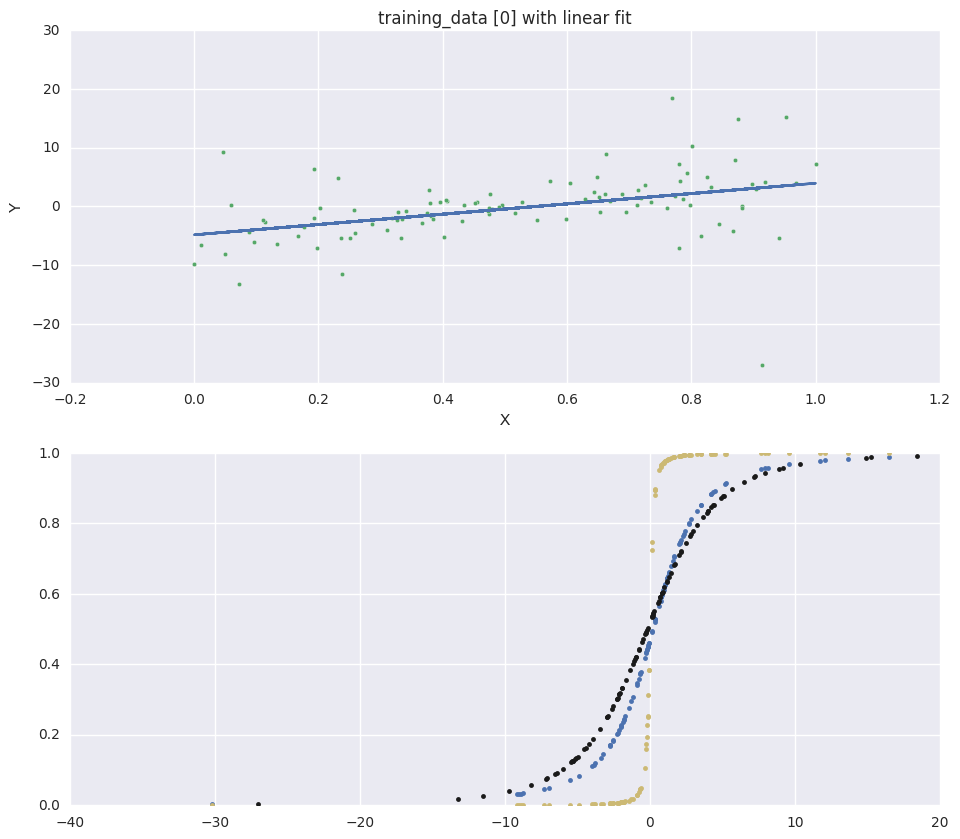

In [176]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax1.scatter(x[:], y[:], s=10, c='g')
ax1.plot(x[:], (est['b0'] + est['b1']*x)[:])
ax1.set_ylabel("Y")
ax1.set_xlabel('X')
ax1.set_title("training_data [{}] with linear fit".format(file_index))
ax1.legend() 


ax2 = fig.add_subplot(212)

# error of the observed data given b1 and b0
error = y - (est['b0'] + est['b1']*x)

# a t dist. fit of the observed error
(df, loc, scale) = stats.t.fit(error)
rv = stats.t(df, loc=loc, scale=scale)
rv_pdf = np.array([e for e in rv.cdf(error)])
ax2.plot(error, rv_pdf, '.', lw=2, label='frozen pdf', c='b')

# a t dist. of the y value from the observed set
(df, loc, scale) = stats.t.fit(y)
rv = stats.t(df, loc=loc, scale=scale)
rv_pdf = np.array([e for e in rv.cdf(y)])
ax2.plot(y, rv_pdf, '.', lw=2, label='frozen pdf', c='k')


# t dist of the error value from MCMC
rv = stats.t(est['nu'], loc=0, scale=est['lam'])
rv_pdf = np.array([e for e in rv.cdf(error)])
ax2.plot(error, rv_pdf, '.', lw=2, label='frozen pdf', c='y')

fig.show()

In [70]:
type(pm.summary(trace))


b0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -5.572           0.701            0.016            [-6.914, -4.249]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -6.903         -6.052         -5.580         -5.090         -4.229


b1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.634           1.269            0.030            [8.222, 13.107]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.190          9.774          10.611         11.501         13.083


lam:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------

NoneType

In [148]:
summary(trace)


b0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -5.548           0.672            0.028            [-6.878, -4.271]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -6.841         -6.003         -5.559         -5.125         -4.195


b1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.594           1.229            0.051            [8.172, 12.985]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.147          9.819          10.621         11.414         12.977


lam:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------